#### POLYGON - POLYGON INTERSECTION
##### Author: Simone Poncioni, MSB
##### Date: 03.10.2022

<div>
<img src="Intersection_01.jpg" width="1000"/>
</div>

### Check and correct minimal thickness

#### Hypotheses:
- Internal array must be always internal (no intersection)
- No self intersection of the polygons
- Both arrays indexes increase counter clockwise (ccw) --> already checked previously

#### Procedure:
1. Get [x_e, y_e] and [x_i, y_i] coordinates arrays (slice-wise)
2. Get normals of [(x_n+1 - x_n), (y_n+1 - y_n)]:

`norm = math.hypot(dx, dy) * 1/min_thickness`

3. Check number of elements, otherwise resample evenly spaced points of len([ext])
4. Check array indexing (x_1_ext =!= x_1_int)
5. Check min thickness --> store it in a boolean array of [True, ..., False], where True if:
   
`bool_min_thickness = [i<min_thickness for i in dist]`      with     `dist = np.sqrt(dist_x**2 + dist_y**2)`

6. Where True, correct internal position of the point by moving the end point of the segment by `[arr[:, 0] - dy, arr[:, 1] + dx]` (where dx, dy already include min thickness requested (see pt. 2)) 
7. Update [x_i, y_i] coordinates array without impacting external coordinates


#### TODOS:
- In implementation make sure ccw check comes before checking distances (otherwise arrays will become more and more distant)
- Check for inter-polygon intersection and how to handle it

##### Imports and configurations

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('white')

# rcParams
f = 1
plt.rcParams['figure.figsize'] = [10 * f, 10 * f]
plt.rcParams['font.size'] = 15

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

##### Functions and helpers

In [2]:
def check_intersection(ext, int, min_thickness=1):
    """
    Checks thickness of ext, int arrays and returns a list of booleans
    of form [True, ..., False] where True means the thickness if below tolerance.

    Arguments:
        ext {ndarray} -- array of [x, y] points of external polygon
        int {ndarray} -- array of [x, y] points of internal polygon
        min_thickness {float} -- minimum thickness tolerance between ext/int

    Returns:
        bool_min_thickness {list}  -- list indicating where the thickness is below tolerance
    """    

    dist_x = ext[:, 0] - int[:, 0]
    dist_y = ext[:, 1] - int[:, 1]
    dist = np.sqrt(dist_x**2 + dist_y**2)

    bool_min_thickness = [i<min_thickness for i in dist]
    return bool_min_thickness


def correct_internal_point(arr, dx, dy):
    """
    Corrects [x, y] position of points of internal array

    Args:
        arr (ndarray): array of internal perimeter
        dx (float): normal component x * minimum thickness
        dy (float): normal component y * minimum thickness

    Returns:
        ndarray: new position of internal points in array 'arr'
    """
    return np.array([arr[:, 0] - dy, arr[:, 1] + dx]).transpose()


def correct_intersection(ext_arr, int_arr, dx, dy, bool_min_thickness):
    """
    Takes external and internal arrays and applies nodal displacement to the elements where bool_min_thickness == True

    Args:
        ext_arr (ndarray): array of [x, y] external points composing the perimeter
        int_arr (ndarray): array of [x, y] internal points composing the perimeter
        dx (float): normal component x * minimum thickness
        dy (float): normal component y * minimum thickness
        bool_min_thickness (list): list indicating where the thickness is below tolerance

    Returns:
        ndarray: new array of internal polygon
    """
    bool_min_thickness = np.c_[bool_min_thickness, bool_min_thickness]
    int_corr = correct_internal_point(ext_arr, dx, dy)
    np.copyto(dst=int_arr, src=int_corr, where=bool_min_thickness)
    return int_arr


def draw_arrow(ax, arr_start, arr_end, text, color):
    """
    Helper that draws normals with arrow and vector annotation

    Args:
        ax (AxesSubplot): ax where to add the arrow
        arr_start (tuple): tuple of arrow starting point
        arr_end (tuple): tuple of arrow ending point
        text (str): string of text to add as annotation
        color (str): color of arrow + annotation
    """
    dx = arr_end[0] - arr_start[0]
    dy = arr_end[1] - arr_start[1]
    ax.arrow(arr_start[0], arr_start[1], dx, dy, head_width=0.01, head_length=0.01, length_includes_head=True, color=color)
    ax.annotate(text, xy=(arr_end[0], arr_end[1]), xytext=(arr_end[0]-25, arr_end[1]-35), color=color, 
             xycoords = 'data', textcoords="offset points",
             size=16, va="center")
    return None


def get_normals(xs, ys, ax1, ax2, thickness=1):
    """
    Get normal arrays point-wise for array [xs, ys]
    
    # TODO: needs some optimization (array operations)
    

    Args:
        xs (ndarray): x-component of contour array
        ys (ndarray): y-component of contour array
        ax1 (AxesSubplot): ax subplot 1
        ax2 (AxesSubplot): ax subplot 2
        thickness (int, optional): Minimum thickness of int-ext interface. Defaults to 1.

    Returns:
        dx_arr (ndarray): array of dx component of the normals
        dy_arr (ndarray): array of dy component of the normals
        dx_med (ndarray): array of resultant normal between (x_n and x_n+1)
        dy_med (ndarray): array of resultant normal between (y_n and y_n+1)
    """
    dx_arr = []
    dy_arr = []
    for idx in range(len(xs)-1):
        x0, y0, xa, ya = xs[idx], ys[idx], xs[idx+1], ys[idx+1]
        dx, dy = xa-x0, ya-y0
        norm = math.hypot(dx, dy) * 1/thickness
        dx /= norm
        dy /= norm

        dx_arr = np.append(dx_arr, dx)
        dy_arr = np.append(dy_arr, dy)
        ax1.plot(((x0+xa)/2, (x0+xa)/2-dy), ((y0+ya)/2, (y0+ya)/2+dx), color='tab:grey')    # plot the normals
        draw_arrow(ax2, (x0, y0), (x0-dy, y0+dx), text=' ', color='tab:grey')
        draw_arrow(ax2, (xa, ya), (xa-dy, ya+dx), text=' ', color='tab:grey')

    dx_arr = np.append(dx_arr, dx_arr[0])
    dy_arr = np.append(dy_arr, dy_arr[0])

    dx_med = []
    for dx in range(len(dx_arr)-1):
        dx_med_s = (dx_arr[dx] + dx_arr[dx+1]) * 0.5
        dx_med = np.append(dx_med, dx_med_s)
    
    dy_med = []
    for dy in range(len(dy_arr)-1):
        dy_med_s = (dy_arr[dy] + dy_arr[dy+1]) * 0.5
        dy_med = np.append(dy_med, dy_med_s)

    dx_med = np.insert(dx_med, 0, dx_med[0])
    dy_med = np.insert(dy_med, 0, dy_med[0])

    for idx in range(len(xs)-1):
        x0, y0, xa, ya = xs[idx], ys[idx], xs[idx+1], ys[idx+1]
        draw_arrow(ax2, (x0, y0), (x0-dy_med[idx], y0+dx_med[idx]), text='$\\vec{n}_{res}$', color='tab:green')

    return dx_arr, dy_arr, dx_med, dy_med


def get_circle(radius, center, n_points=15):
    """
    Get a circle to create synthetic test data

    Args:
        radius (float): radius of the circle
        center (list): center of the circle
        n_points (int): number of points that compose the circle. Defaults to 15.

    Returns:
        x_s (ndarray): array containing x position of circle
        y_s (ndarray): array containing y position of circle
    """
    angles = np.linspace(0 * np.pi, 2 * np.pi, n_points)
    xs = radius * np.cos(angles) + center[0]
    ys = radius * np.sin(angles) + center[1]
    return xs, ys


def show_circles(center, n_points=15, min_thickness=1):
    """
    Create circles, get normals, plot

    Args:
        center (list): center of the circle
        n_points (int): number of points that compose the circle. Defaults to 15.
        min_thickness (int, optional): Minimum thickness of int-ext interface. Defaults to 1.

    Returns:
        ext_a (ndarray): 2D array of [x, y] points
        int_a (ndarray): 2D array of [x, y] points
        dx_arr (ndarray): array of dx component of the normals
        dy_arr (ndarray): array of dy component of the normals
        dx_med (ndarray): array of resultant normal between (x_n and x_n+1)
        dy_med (ndarray): array of resultant normal between (y_n and y_n+1)
        fig (matplotlib.figure.Figure): figure
        ax1 (AxesSubplot): ax subplot
        ax2 (AxesSubplot): ax subplot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.plot(center[0], center[1], color = 'red', marker = 'o', label='center')
    ax1.annotate(f'O {center}', xy=(center[0] + 1, center[1] - 1), xycoords='data')
    x_ext, y_ext = get_circle(radius=15, center=center, n_points=n_points)
    x_int, y_int = get_circle(radius=14.99, center=center, n_points=n_points)
    
    dx, dy, dx_med, dy_med = get_normals(x_ext, y_ext, ax1, ax2, thickness=min_thickness)

    ext_a = np.c_[x_ext, y_ext]
    int_a = np.c_[x_int, y_int]
    
    ax1.plot(x_ext, y_ext, label='external contour')
    ax2.plot(x_ext, y_ext)
    ax1.plot(x_int, y_int, label='initial internal contour')
    ax2.plot(x_int, y_int)
    return ext_a, int_a, dx, dy, dx_med, dy_med, fig, ax1, ax2


##### Main

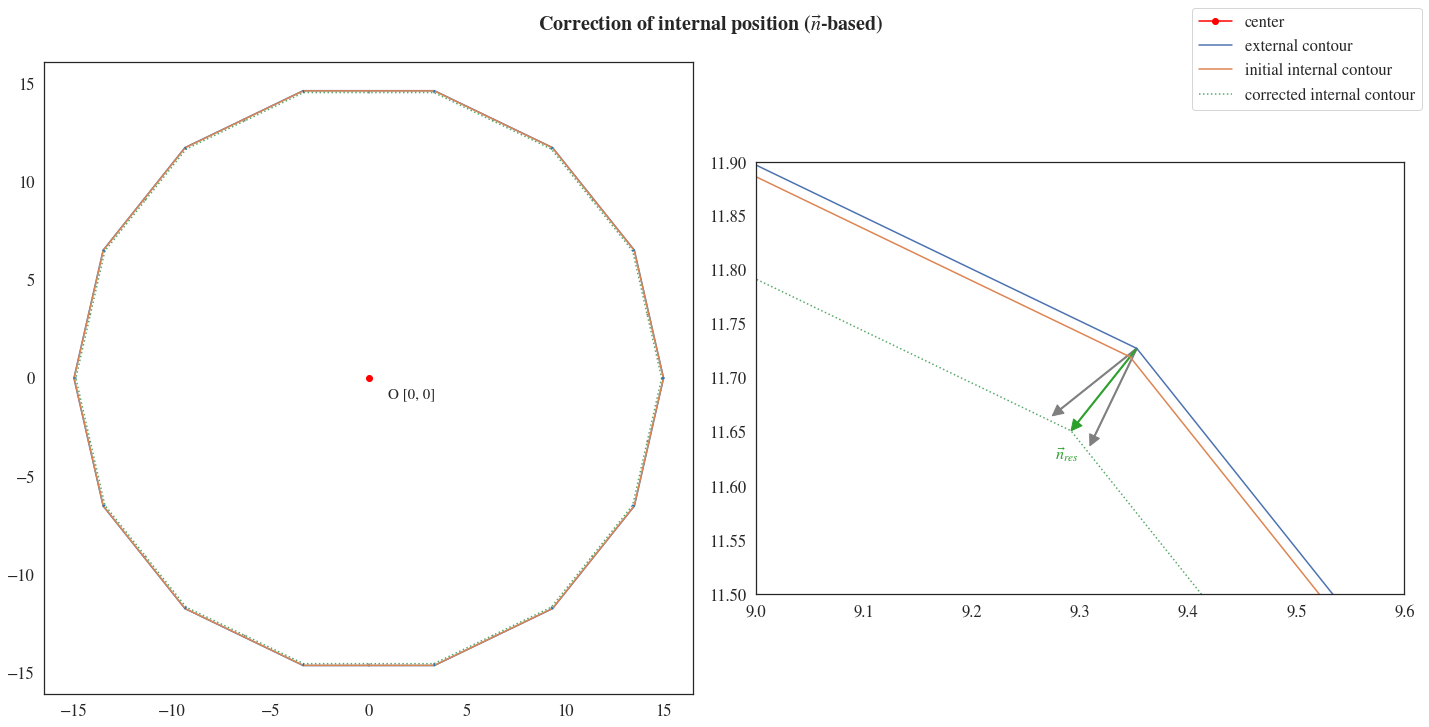

In [3]:
# PARAMS
c = [0, 0]
MIN_THICKNESS = 100e-3
N_POINTS = 15

# MAIN
ext_s, int_s, dx, dy, dx_med, dy_med, fig, ax1, ax2 = show_circles(center=c, n_points=N_POINTS, min_thickness=MIN_THICKNESS)
bool_min_thickness_s = check_intersection(ext=ext_s, int=int_s, min_thickness=MIN_THICKNESS)
new_int = correct_intersection(
    ext_arr=ext_s,
    int_arr=int_s,
    dx=dx_med,
    dy=dy_med,
    bool_min_thickness=bool_min_thickness_s
)

ax1.plot(new_int[:, 0], new_int[:, 1], linestyle=':', label='corrected internal contour')
ax2.plot(new_int[:, 0], new_int[:, 1], linestyle=':')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax2.set_xlim(9, 9.6)
ax2.set_ylim(11.5, 11.9)
fig.suptitle('Correction of internal position ($\\vec{n}$-based)', weight='bold', fontsize=20)
fig.legend(loc=1)
fig.tight_layout()


ax1.plot((ext_s[:, 0], ext_s[:, 0]-dy_med), (ext_s[:, 1], ext_s[:,1]+dx_med), color='tab:blue')
# fig.savefig('Correction_internal_position.svg')
print('')

- - -
#### Test above code on real slice

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as shpg
from scipy.interpolate import splev, splprep
from scipy import spatial

In [5]:
def offset_surface(ext_line, offset):
    '''
    Create artificial internal surface based on an offset
    Don't implement in main script it's just for testing
    '''
    # Create a Polygon from the 2d array
    poly = shpg.Polygon(ext_line)

    # Create offset in inward direction
    noffpoly = poly.buffer(-1 * offset)  # Inward offset

    # Turn polygon points into numpy arrays for plotting
    afpolypts = np.array(poly.exterior)
    noffafpolypts = np.array(noffpoly.exterior)
    return noffafpolypts


def resample_polygon(xy: np.ndarray, n_points: int = 100) -> np.ndarray:
    """
    Cumulative Euclidean distance between successive polygon points.

    Args:
        xy (np.ndarray): 2D-array of [x, y] contour
        n_points (int, optional): Number of points to resample contour. Usually len(ext contour). Defaults to 100.

    Returns:
        np.ndarray: Resampled contour [x, y]
    """
    d = np.cumsum(np.r_[0, np.sqrt((np.diff(xy, axis=0) ** 2).sum(axis=1))])

    # get linearly spaced points along the cumulative Euclidean distance
    d_sampled = np.linspace(0, d.max(), n_points)

    # interpolate x and y coordinates
    xy_interp = np.c_[
        np.interp(d_sampled, d, xy[:, 0]),
        np.interp(d_sampled, d, xy[:, 1]),
    ]
    return xy_interp

#### Create artificial data

/tmp/ipykernel_14337/2007164751.py:3: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  int_spline = offset_surface(ext_spline, offset=1e-3)


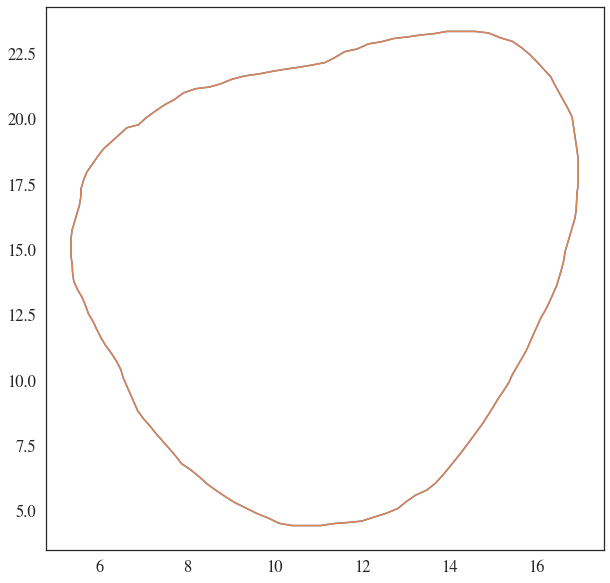

In [6]:
ext_path = r'ext_surf_slice_minus1.npy'
ext_spline = np.load(ext_path)
int_spline = offset_surface(ext_spline, offset=1e-3)
int_spline = resample_polygon(int_spline, n_points=len(ext_spline))
ext_spline = resample_polygon(ext_spline, n_points=len(ext_spline))

np.save('int_spline_minus1.npy', int_spline)

plt.figure(figsize=(10, 10))
plt.plot(ext_spline[:, 0], ext_spline[:, 1])
plt.plot(int_spline[:, 0], int_spline[:, 1])
print('')

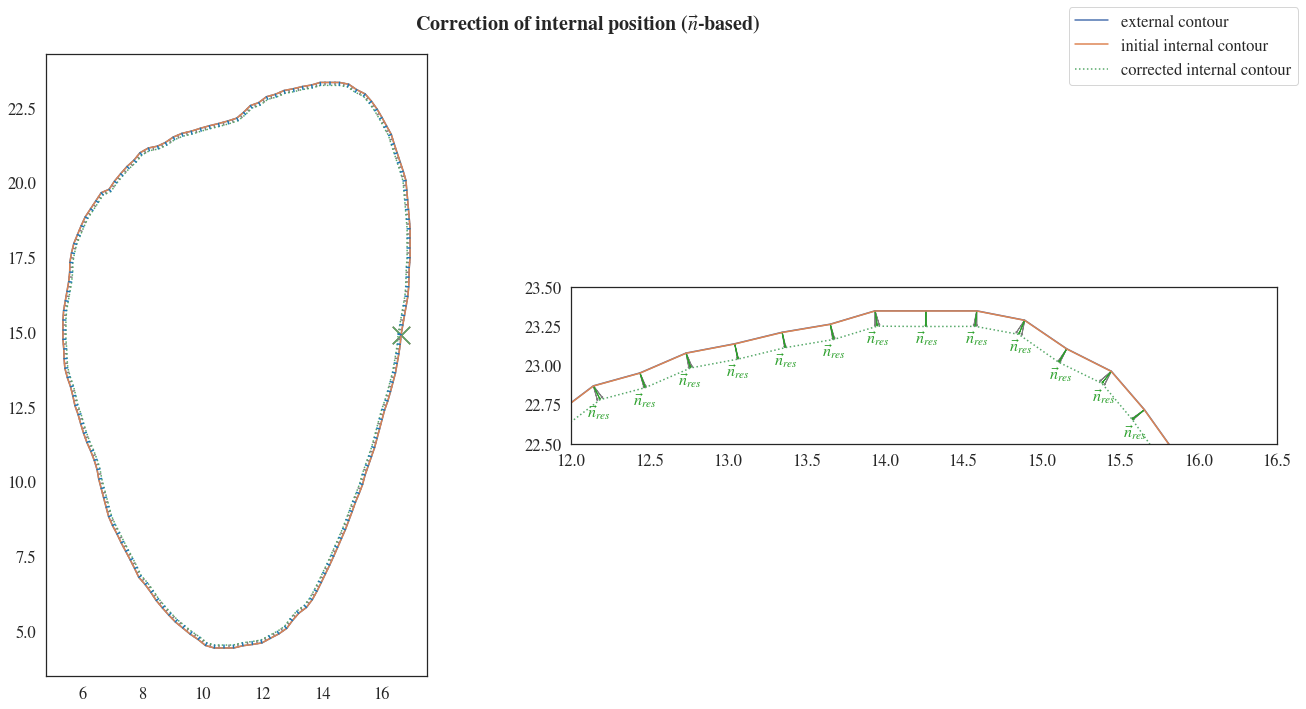

In [7]:
def nearest_point(arr, pt):
    """
    Find nearest point between an array and a point (e.g. the first point of ext contour)

    Args:
        arr (ndarray): 2D array of contour
        pt (list): (x, y) coordinates of point

    Returns:
        loc (numpy.ndarray): location of nearest point in the array
        dist (float): distance between point and nearest point in array
        idx (numpy.int64): index of point in array
    """
    dist, idx = spatial.KDTree(arr).query(pt)
    loc = arr[spatial.KDTree(arr).query(pt)[1]]
    return loc, dist, idx


def show_centres(min_thickness, x_ext, y_ext, x_int, y_int):
    """
    Create contours, get normals, plot

    Args:
        min_thickness (int): Minimum thickness of int-ext interface.
        x_ext (ndarray): array of [x] component of external array
        y_ext (ndarray): array of [y] component of external array
        x_int (ndarray): array of [x] component of internal array
        y_int (ndarray): array of [y] component of internal array

    Returns:
        ext_a (ndarray): 2D array of [x, y] points
        int_a (ndarray): 2D array of [x, y] points
        dx_arr (ndarray): array of dx component of the normals
        dy_arr (ndarray): array of dy component of the normals
        dx_med (ndarray): array of resultant normal between (x_n and x_n+1)
        dy_med (ndarray): array of resultant normal between (y_n and y_n+1)
        fig (matplotlib.figure.Figure): figure
        ax1 (AxesSubplot): ax subplot
        ax2 (AxesSubplot): ax subplot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    dx, dy, dx_med, dy_med = get_normals(x_ext, y_ext, ax1, ax2, thickness=min_thickness)

    ext_a = np.c_[x_ext, y_ext]
    int_a = np.c_[x_int, y_int]
    
    ax1.plot(x_ext, y_ext, label='external contour')
    ax2.plot(x_ext, y_ext)
    ax1.plot(x_int, y_int, label='initial internal contour')
    ax2.plot(x_int, y_int)
    return ext_a, int_a, dx, dy, dx_med, dy_med, fig, ax1, ax2


# TODO: invert order in function rather than in real data (ONLY for testing)
ext_spline[:, 0] = np.flip(ext_spline[:, 0])
ext_spline[:, 1] = np.flip(ext_spline[:, 1])
int_spline[:, 0] = np.flip(int_spline[:, 0])
int_spline[:, 1] = np.flip(int_spline[:, 1])

loc_int, dist_int, idx_int = nearest_point(int_spline, [ext_spline[0, 0], ext_spline[0, 1]])

int_in = int_spline[idx_int:, :]
int_f = int_spline[:idx_int, :]
int_spline = np.r_[int_in, int_f]

# MAIN
# PARAMS
MIN_THICKNESS = 100e-3

ext_s, int_s, dx, dy, dx_med, dy_med, fig, ax1, ax2 = show_centres(min_thickness=MIN_THICKNESS,
                                                                   x_ext=ext_spline[:, 0],
                                                                   y_ext=ext_spline[:, 1],
                                                                   x_int=int_spline[:, 0],
                                                                   y_int=int_spline[:, 1])
bool_min_thickness_s = check_intersection(ext=ext_s, int=int_s, min_thickness=MIN_THICKNESS)
new_int = correct_intersection(
    ext_arr=ext_s,
    int_arr=int_s,
    dx=dx_med,
    dy=dy_med,
    bool_min_thickness=bool_min_thickness_s
)

ax1.scatter(ext_spline[0,0], ext_spline[0, 1], marker='x', s=300)
ax1.scatter(int_spline[0,0], int_spline[0, 1], marker='x', s=300)
ax1.scatter(loc_int[0], loc_int[1], marker='x', s=300)

ax1.plot(new_int[:, 0], new_int[:, 1], linestyle=':', label='corrected internal contour')
ax2.plot(new_int[:, 0], new_int[:, 1], linestyle=':')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax2.set_xlim(12, 16.5)
ax2.set_ylim(22.5, 23.5)
fig.suptitle('Correction of internal position ($\\vec{n}$-based)', weight='bold', fontsize=20)
fig.legend(loc=1)
fig.tight_layout()


ax1.plot((ext_s[:, 0], ext_s[:, 0]-dy_med), (ext_s[:, 1], ext_s[:,1]+dx_med), color='tab:blue')
# fig.savefig('Correction_internal_position_mwe.svg')
# fig.savefig('Correction_internal_position_mwe.png', dpi=300)
print('')